In [28]:
# %pip install datasets matplotlib torch shap
# %pip install transformers
# %pip install lime

In [29]:

from custom_model import EmotionClassifier
from datasets import load_dataset 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader 
import shap 

In [30]:

with open("dict.txt", "r") as f:
    emotion_dict = [line.strip() for line in f]

emotion_dict

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

In [31]:



classifier = EmotionClassifier(device='cpu')  




print("Loading go_emotions dataset...")
dataset = load_dataset("go_emotions", "simplified")





data_subset = dataset['train'].shuffle(seed=42)#.select(range(4500))  

all_texts = data_subset['text']
all_labels = data_subset['labels'] 
all_labels = [label[0] for label in all_labels]  
all_labels = [emotion_dict[int(label)] for label in all_labels]


train_texts, val_texts = all_texts[:4000], all_texts[4000:4500]
train_labels, val_labels = all_labels[:4000], all_labels[4000:4500]
print(f"Loaded {len(train_texts)} training samples and {len(val_texts)} validation samples.")

Loading go_emotions dataset...
Loaded 4000 training samples and 500 validation samples.


In [32]:
import random
from collections import Counter

def create_stratified_dataset(all_texts_raw, all_labels_raw, dataset_size, random_seed=42):
    """
    Create a stratified dataset with equal representation for each emotion class
    
    Args:
        all_texts_raw: List of input texts
        all_labels_raw: List of emotion labels
        dataset_size: Desired total size of the final dataset
        random_seed: Random seed for reproducibility
        
    Returns:
        all_texts_stratified: Balanced texts dataset
        all_labels_stratified: Balanced labels dataset
    """
    random.seed(random_seed)
    
    # Group data by emotion
    emotion_to_samples = {}
    for text, emotion in zip(all_texts_raw, all_labels_raw):
        if emotion not in emotion_to_samples:
            emotion_to_samples[emotion] = []
        emotion_to_samples[emotion].append(text)
    
    # Get unique emotions
    unique_emotions = list(emotion_to_samples.keys())
    num_emotions = len(unique_emotions)
    
    # Calculate samples per emotion
    samples_per_emotion = dataset_size // num_emotions
    remainder = dataset_size % num_emotions
    
    print(f"Creating stratified dataset with {dataset_size} total samples")
    print(f"Number of unique emotions: {num_emotions}")
    print(f"Base samples per emotion: {samples_per_emotion}")
    
    # Create balanced dataset
    all_texts_stratified = []
    all_labels_stratified = []
    
    for i, emotion in enumerate(unique_emotions):
        available_samples = emotion_to_samples[emotion]
        
        # Handle case where we need more samples than available
        if samples_per_emotion > len(available_samples):
            print(f"Warning: Not enough samples for emotion '{emotion}'. "
                  f"Needed {samples_per_emotion}, but only {len(available_samples)} available.")
            # Take all available samples and use them with replacement if needed
            needed_extras = samples_per_emotion - len(available_samples)
            selected_samples = available_samples.copy()
            selected_samples.extend(random.choices(available_samples, k=needed_extras))
        else:
            # Add one extra sample to some emotions to handle remainder
            current_samples = samples_per_emotion + (1 if i < remainder else 0)
            selected_samples = random.sample(available_samples, current_samples)
        
        all_texts_stratified.extend(selected_samples)
        all_labels_stratified.extend([emotion] * len(selected_samples))
    
    # Shuffle the balanced dataset to avoid sequential bias
    combined = list(zip(all_texts_stratified, all_labels_stratified))
    random.shuffle(combined)
    all_texts_stratified, all_labels_stratified = zip(*combined)
    
    # Convert to lists (from tuples)
    all_texts_stratified = list(all_texts_stratified)
    all_labels_stratified = list(all_labels_stratified)
    
    # Verify class distribution
    label_counts = Counter(all_labels_stratified)
    print("\nEmotion distribution in stratified dataset:")
    for emotion, count in label_counts.items():
        percentage = 100 * count / len(all_labels_stratified)
        print(f"  {emotion}: {count} samples ({percentage:.1f}%)")
    
    return all_texts_stratified, all_labels_stratified

# Usage example - add this where you want to create the balanced dataset
dataset_size = 4500  # Set your desired size here

# Load the original dataset first
data_subset = dataset['train'].shuffle(seed=43)#.select(range(4500))
all_texts = data_subset['text']
all_labels = data_subset['labels']
all_labels = [label[0] for label in all_labels]
all_labels = [emotion_dict[int(label)] for label in all_labels]

# Create the stratified dataset
all_texts_stratified, all_labels_stratified = create_stratified_dataset(
    all_texts, all_labels, dataset_size, random_seed=43)

print(f"\nFinal dataset size: {len(all_texts_stratified)} samples")

Creating stratified dataset with 4500 total samples
Number of unique emotions: 28
Base samples per emotion: 160

Emotion distribution in stratified dataset:
  sadness: 160 samples (3.6%)
  joy: 161 samples (3.6%)
  pride: 160 samples (3.6%)
  approval: 161 samples (3.6%)
  gratitude: 161 samples (3.6%)
  neutral: 161 samples (3.6%)
  anger: 161 samples (3.6%)
  relief: 160 samples (3.6%)
  optimism: 161 samples (3.6%)
  disapproval: 161 samples (3.6%)
  admiration: 161 samples (3.6%)
  annoyance: 161 samples (3.6%)
  desire: 161 samples (3.6%)
  disappointment: 161 samples (3.6%)
  surprise: 161 samples (3.6%)
  curiosity: 161 samples (3.6%)
  fear: 160 samples (3.6%)
  love: 161 samples (3.6%)
  disgust: 161 samples (3.6%)
  embarrassment: 161 samples (3.6%)
  excitement: 160 samples (3.6%)
  caring: 161 samples (3.6%)
  amusement: 161 samples (3.6%)
  realization: 161 samples (3.6%)
  confusion: 161 samples (3.6%)
  grief: 160 samples (3.6%)
  nervousness: 160 samples (3.6%)
  remors

In [33]:
all_labels=all_labels_stratified.copy()
all_texts=all_texts_stratified.copy()

train_texts, val_texts = all_texts[:4000], all_texts[4000:4500]
train_labels, val_labels = all_labels[:4000], all_labels[4000:4500]

/tmp/ipykernel_14306/1733700636.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=all_labels_stratified, order=sorted_emotion_names, palette='viridis')


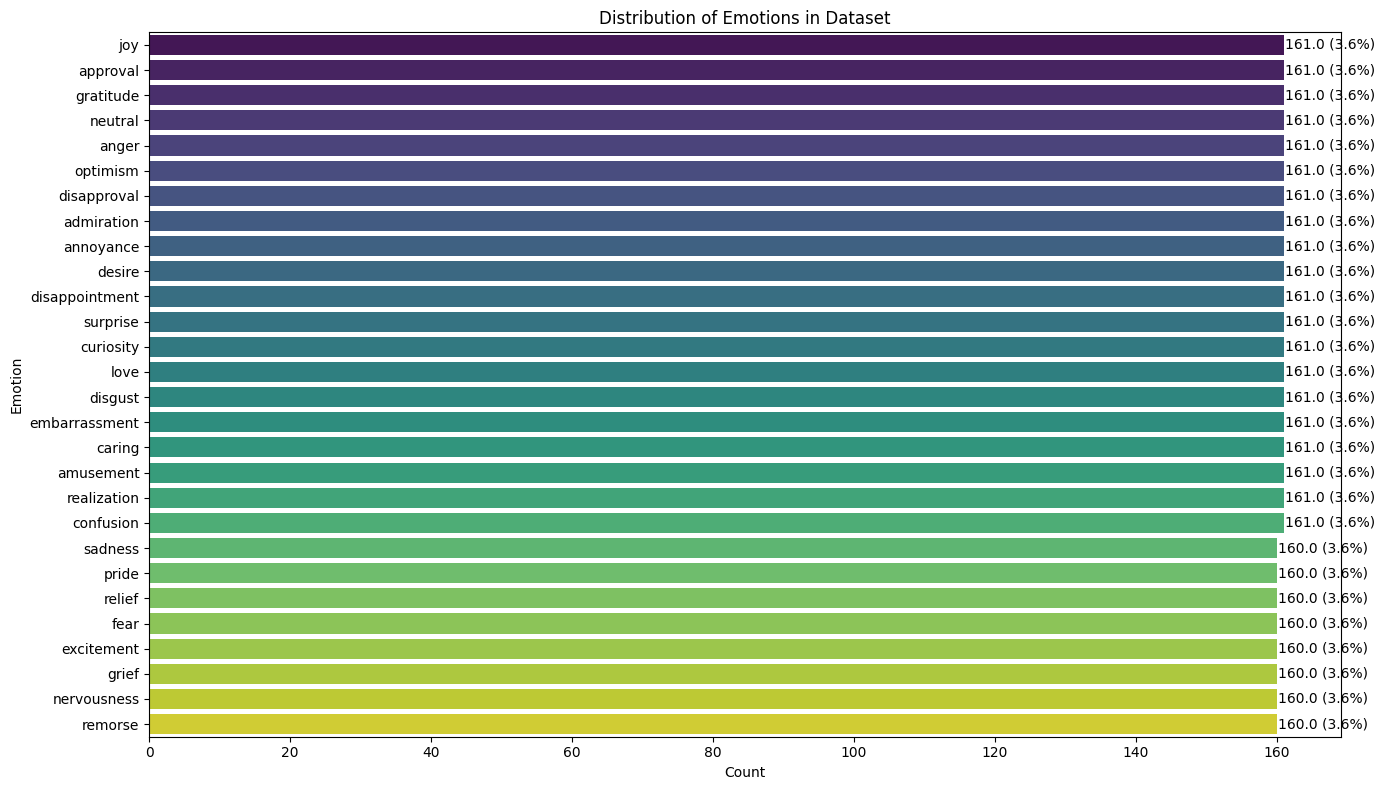

In [34]:
# show labels distribution on chart sorted by frequency with percentages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Count occurrences of each emotion
emotion_counts = {}
for emotion in all_labels_stratified:
    if emotion in emotion_counts:
        emotion_counts[emotion] += 1
    else:
        emotion_counts[emotion] = 1

# Sort emotions by count (descending)
sorted_emotions = sorted(emotion_counts.items(), key=lambda x: x[1], reverse=True)
sorted_emotion_names = [item[0] for item in sorted_emotions]
total_samples = len(all_labels_stratified)

plt.figure(figsize=(14, 8))
ax = sns.countplot(y=all_labels_stratified, order=sorted_emotion_names, palette='viridis')

# Add percentage labels to each bar
for i, p in enumerate(ax.patches):
    count = p.get_width()
    percentage = 100 * count / total_samples
    ax.annotate(f'{count} ({percentage:.1f}%)', 
                (count + 0.1, p.get_y() + p.get_height()/2),
                va='center')

plt.title('Distribution of Emotions in Dataset')
plt.xlabel('Count')
plt.ylabel('Emotion')
plt.tight_layout()
plt.show()

In [35]:

import random
random_index = random.randint(0, len(train_texts) - 1)
print(f"Sample text: {train_texts[random_index]}")
print(f"Sample labels: {train_labels[random_index]}")

Sample text: At least she can eat Abel or something so we don't have to worry about feeding her.
Sample labels: relief


In [36]:



print("Starting training...")
classifier.train(
    train_texts, train_labels,
    val_texts, val_labels,
    learning_rate=0.00001,
    epochs=20,  
    batch_size=16  
)

Starting training...
Labels setup: 28 unique labels found: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'neutral', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise']
Epoch 1/20 batch 250/250
  Train Loss: 3.1906
  Val Accuracy: 0.3180
  Val F1 Macro: 0.2726
  Val ROC AUC (Macro OVR): 0.8339
  New best model saved with F1 Macro: 0.2726
Epoch 2/20 batch 250/250
  Train Loss: 2.3183
  Val Accuracy: 0.5160
  Val F1 Macro: 0.4897
  Val ROC AUC (Macro OVR): 0.9115
  New best model saved with F1 Macro: 0.4897
Epoch 3/20 batch 250/250
  Train Loss: 1.6972
  Val Accuracy: 0.5840
  Val F1 Macro: 0.5620
  Val ROC AUC (Macro OVR): 0.9236
  New best model saved with F1 Macro: 0.5620
Epoch 4/20 batch 250/250
  Train Loss: 1.3143
  Val Accuracy: 0.5880
  Val F1 Macro: 0.5579
  

In [37]:


#test the model on example text
example_text = "i want to cry, depression is coming"
predicted_labels = classifier.predict([example_text])
print(f"Predicted labels for '{example_text}': {predicted_labels}")

Predicted labels for 'i want to cry, depression is coming': {'curiosity': 0.1999381184577942}


In [38]:
# # 6. Show SHAP explanation (for one example)
# print("Generating SHAP explanation...")
# shap_explanation = classifier.explain_shap(test_text)
# shap.plots.text(shap_explanation)


In [39]:

# # 7. Show LIME explanation
# print("\nGenerating LIME explanation...")
# lime_explanation = classifier.explain_lime(test_text)
# lime_explanation.show_in_notebook()
